In [3]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import WMAP9
from scipy.optimize import curve_fit

In [4]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 150
plt.rc('text',usetex=True)

## Halo mass estimation (stellar-halo mass relation)

from Alexie Leauthaud et al. 2012

In [5]:
# SHMR
M1 = 10**12.52
Ms0 = 10**10.916
beta = 0.457
delta = 0.566
gamma = 1.53

def mh(log_Ms):
    Ms = 10**log_Ms
    log_mh = np.log10(M1)+beta*np.log10(Ms/Ms0)+(Ms/Ms0)**delta/(1+(Ms/Ms0)**(-1*gamma))-0.5
    return log_mh

def r_200(log_Ms):
    # r200 in kpc
    rho_bar = 9.9e-30 # g/cm^3
    log_Mh = mh(log_Ms)
    return ((3*10**log_Mh*1.989e30*1e3)/(800*np.pi*rho_bar))**(1/3)/3.086e21

In [6]:
mh(13)

28.08232765313585

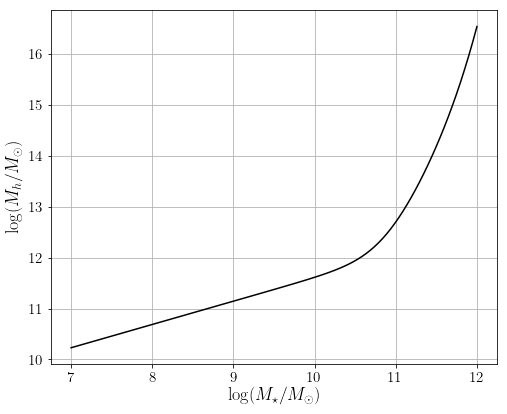

In [34]:
log_Ms = np.linspace(7,12,100)
log_Mh = mh(log_Ms)

fig, axs = plt.subplots(1, 1, figsize=(8,6.5))
plt.plot(log_Ms,log_Mh,'k')
plt.xlabel('$\log(M_\star/M_\odot)$',fontsize=18)
plt.ylabel('$\log(M_h/M_\odot)$',fontsize=18)
plt.grid()

plt.savefig('figures/mh_hs.png')

## histogram of stellar/halo masses

very important to know just what it is

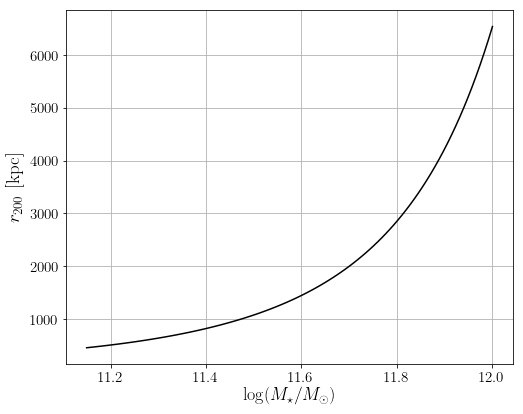

In [35]:
# r200 estimation
log_Ms = np.linspace(11.15,12.0,100)
r200 = r_200(log_Ms)

fig, axs = plt.subplots(1, 1, figsize=(8,6.5))
plt.plot(log_Ms,r200,'k')
plt.xlabel('$\log(M_\star/M_\odot)$',fontsize=18)
plt.ylabel('$r_{200}$ [kpc]',fontsize=19)
plt.grid()

plt.savefig('figures/ms_r200.png')

In [9]:
# histogram of r200's


## NFW

In [10]:
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

## Number density profile scaled to $r_{200}$

In [11]:
def combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path):
    try:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(z)+'.txt'
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    except IOError:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(z)
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = np.vstack([radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais])

    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial, radial_err, sum(n_combine))

[32.40148199 50.48085287 50.93995787 45.35964404 39.87202018 30.2755269
 16.75174474 11.36861649  7.9520346   6.14877368  4.31837957  3.42212778
  1.92123959  1.01460015]
c = 3.2529544957898984


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arctanh
  after removing the cwd from sys.path.
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in arctanh
  after removing the cwd from sys.path.


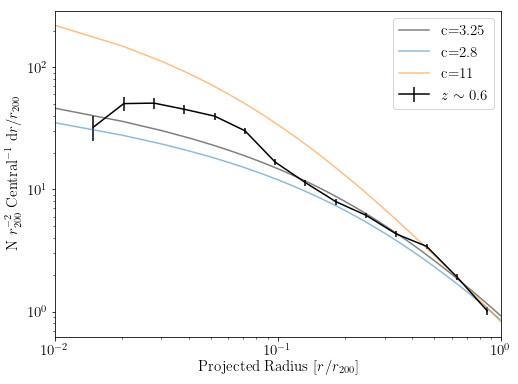

In [33]:
z=0.6
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))

path = 'CUT_deep_catalogs/total_sample_r200/'
radial_2 = combine_deep('all','all','9.5','inf',z, path)
bin_centers = np.load(path+'bin_centers.npy')
print(radial_2[0])

plt.errorbar(bin_centers, radial_2[0],yerr=radial_2[1],fmt='k',label='$z\sim$ '+str(z))

## NFW overlay
fit_x = np.linspace(0,1,num=100)
popt,pcov,chi2 = fit_nfw(bin_centers,radial_2[0],radial_2[1], 7)
plt.plot(fit_x,nfw(fit_x,popt[0],popt[1]),'k',alpha=0.5,label='c='+str(round(1/popt[0],2)))
plt.plot(fit_x,nfw(fit_x,1/2.8,popt[1])/nfw(0.9,1/2.8,popt[1]),alpha=0.5,label='c=2.8')
plt.plot(fit_x,nfw(fit_x,1/11,popt[1])/nfw(0.9,1/11,popt[1]),alpha=0.5,label='c=11')
print('c =',1/popt[0])

plt.xlabel('Projected Radius [$r/r_{200}$]', fontsize=15)
plt.ylabel(r'N $r_{200}^{-2}$ Central$^{-1}$ d$r/r_{200}$',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.01,1.0])

plt.savefig('figures/radial_total_'+str(z)+'_r200.png')
plt.show()

## Combine redshift bins plots

Conformity Plot (all redshifts)

do I need to balance the two central samples to have same mass distribution?

In [115]:
def red_frac_err(q, sf, q_err, sf_err):
    return np.sqrt( (sf**2*q_err**2 + q**2*sf_err**2) / ((q+sf)**4) )

# move value<=0 to 1e-10 to avoid bad behavior from plt.fill_between
def aa(array):
    for i in range(len(array)):
        if array[i]<=0:
            array[i] = 1e-10
    return array

In [116]:
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

In [117]:
def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    
    return nfw_val + sersic_val

def fit_nfw_sersic(xdata, ydata, ydata_err, start):
    xdata = xdata[start-1:]
    ydata = ydata[start-1:]
    ydata_err = ydata_err[start-1:]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,2e-5,4e-5,13.1, 5.5]
                          ,bounds=([0, 0, 0 ,0 ,0.5],[1000, 1e-3, 1e-3, 100, 10]))
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2



[1.000e+03 5.409e-06 3.867e-05 3.119e+01 6.108e+00] [9.727e+02 5.560e-06 1.333e-04 5.696e+01 5.163e+01] Chi2_dof=1.0
[8.831e+02 4.463e-06 1.656e-05 3.677e+01 6.180e-01] [2.028e+02 8.499e-07 5.725e-06 6.928e+00 5.779e-01] Chi2_dof=0.73
[9.001e+02 1.796e-06 1.112e-04 1.147e+01 1.000e+01] [9.432e+02 2.138e-06 4.121e-03 2.002e+02 1.787e+02] Chi2_dof=0.68
[3.755e+02 1.690e-05 4.565e-05 3.587e+01 7.248e-01] [4.328e+01 2.113e-06 6.539e-06 2.868e+00 2.713e-01] Chi2_dof=1.83
[4.210e+02 9.122e-06 3.029e-05 3.195e+01 5.000e-01] [6.929e+01 1.508e-06 7.935e-06 3.994e+00 3.344e-01] Chi2_dof=3.74
[2.458e+02 1.092e-05 2.144e-05 3.103e+01 5.000e-01] [2.649e+01 1.439e-06 5.897e-06 3.846e+00 3.235e-01] Chi2_dof=2.19


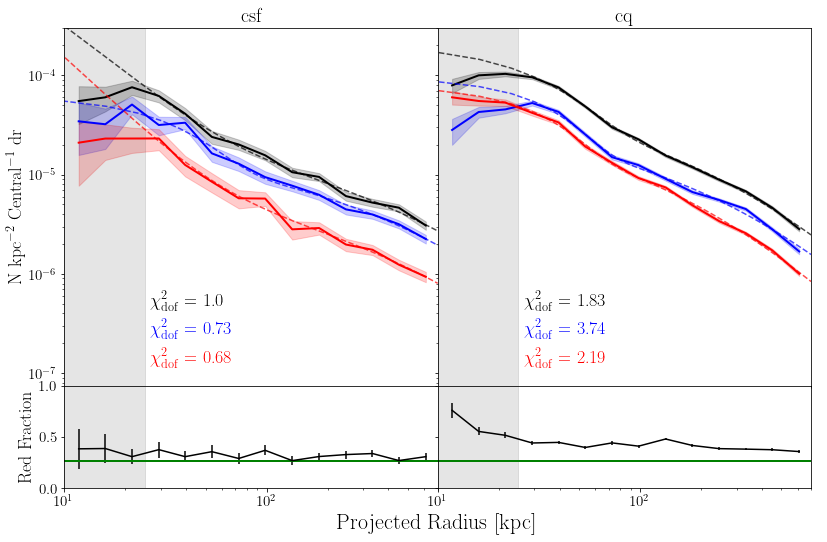

In [151]:
# combine redshift bins
np.set_printoptions(precision=3)
start=4

path = 'CUT_deep_catalogs/conformity/'
bin_edges = np.load(path+'bin_centers.npy') # use bin centers instead

fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize = (12, 8),
                        gridspec_kw={'height_ratios':[3.5,1]})

bin_centers = np.load(path+'bin_centers.npy')
for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    csfq_list = ['csf','cq']
    for j in range(2):
        z=0.4
        axs[0][j].set_title(csfq_list[j],fontsize=20)
        radial_all = combine_deep(csfq_list[j],'all','9.5','inf','allz', path)
        radial_sf = combine_deep(csfq_list[j],'ssf','9.5','inf','allz', path)
        radial_q = combine_deep(csfq_list[j],'sq','9.5','inf','allz', path)
        
        red_err = red_frac_err(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        # plot radial number density profiles
        for radial,color,yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].plot(bin_centers, radial[0],color=color,linewidth=2,label='all')
            axs[i][j].fill_between(bin_centers,radial[0]+radial[1],
                                   aa(radial[0]-radial[1]), alpha=0.2, color=color)
        
            # model fitting
            fit_x = np.linspace(2,700,num=100)        
            popt,pcov,chi2 = fit_nfw_sersic(bin_edges,radial[0],radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            dof = len(bin_edges)-start+1 - len(popt) # degree of freedom
            print(popt,perr,'Chi2_dof='+str(round(chi2/dof,2)))

            axs[i][j].annotate('$\chi^2_\mathrm{dof}$ = '+str(round(chi2/dof,2)),
                               xy=([0.23,yloc]),xycoords='axes fraction',fontsize=18,color=color)
            axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
        
        # red fraction
        axs[1][j].errorbar(bin_edges, red_frac,yerr=red_err,color='k')
        
        # add shaded (non-fitting) region
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([7.5e-8,3e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Red Fraction',fontsize=18)

q_fraction_field = np.genfromtxt('CUT_deep_catalogs/field_q_frac.txt')[int(0.4*10%2)-1]
axs[1][0].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')
axs[1][1].plot([10,700],[q_fraction_field,q_fraction_field],linewidth=2,color='g')


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=22)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/conformity_allz.png')
plt.show()
plt.close()

## Evolution of profiles